In [33]:
""" We use gapminder data regarding population, birthrate, ... to build in animated scatter plot with a dynamically choosable colormap"""

' We use gapminder data regarding population, birthrate, ... to build in animated scatter plot with a dynamically choosable colormap'

In [22]:
import pandas as pd
pd.set_option('display.float_format', '{:.2}'.format)
import os
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [23]:
# load data
try:
    fert = pd.read_csv('./data/gapminder_total_fertility.csv', index_col=0)
    life = pd.read_excel('./data/gapminder_lifeexpectancy.xlsx', index_col=0)
    population = pd.read_excel('./data/gapminder_population.xlsx', index_col=0)
    continents = pd.read_csv('./data/continents.csv', index_col=1)
except OSError:
    print('Input file not found.')

In [24]:
# data preprocessing
del life[life.columns[-1]] # delete last column to match dimensions
continents = continents[['four_regions']] # extract continents
continents = continents.reset_index()
continents = continents.rename(columns={'name':'country', 'four_regions':'continent'})

In [25]:
# match column data type
fert.columns = fert.columns.astype(int)
life.columns = life.columns.astype(int)
population.columns = population.columns.astype(int) 

In [26]:
# prepare all rows and columns for merger
fert.index.name = 'country'
life.index.name = 'country'
population.index.name = 'country'

fert = fert.reset_index()
fert = fert.melt(id_vars='country', var_name='year', value_name='fertility_rate')
life = life.reset_index()
life = life.melt(id_vars='country', var_name='year', value_name='lifeexpectancy_rate')
population = population.reset_index()
population = population.melt(id_vars='country', var_name='year', value_name='population')

In [27]:
# merge it all
df = fert.merge(life)
df = df.merge(population)
df = df.merge(continents)
df.head(5)

,country,year,fertility_rate,lifeexpectancy_rate,population,continent
0,Afghanistan,1800,7.0,2.8e+01,3.3e+06,asia
1,Afghanistan,1810,7.0,2.8e+01,3.3e+06,asia
2,Afghanistan,1820,7.0,2.8e+01,3.3e+06,asia
3,Afghanistan,1830,7.0,2.8e+01,3.4e+06,asia
4,Afghanistan,1840,7.0,2.8e+01,3.6e+06,asia


In [28]:
# show the most populated countries for a given year
year = 2015
pop_overview = population[population['year'] == year]
pop_overview = pop_overview.sort_values(by='population', ascending=False)
pop_overview.head(8)

,country,year,population
22044,China,2015,1.4e+09
22101,India,2015,1.3e+09
22240,United States,2015,3.2e+08
22102,Indonesia,2015,2.6e+08
22029,Brazil,2015,2.1e+08
22171,Pakistan,2015,1.9e+08
22164,Nigeria,2015,1.8e+08
22018,Bangladesh,2015,1.6e+08


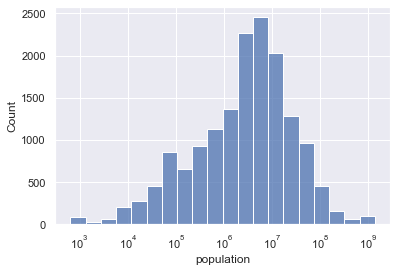

In [29]:
# overview of population by year by histogram
def do_single_histogram(df, year):
    sns.histplot(data=df, x="population", stat='count', bins = 20, log_scale=True)
do_single_histogram(df, 2000)

In [30]:
# clean data and choose specific years only
df = df[df['year']>=1960].reset_index()
df = df.dropna()
df = df.rename(columns={'year': 'Year'})


In [31]:
# draw animated scatter plot with plotly
fig = px.scatter(df, x='lifeexpectancy_rate', y='fertility_rate', animation_frame="Year", animation_group="country", hover_name="country",
                 # range_color=[5,8] symbol="population_level"
                 color="population", color_continuous_scale='Rainbow',
                 size='population', size_max=60, opacity=0.6, range_color=(0, 3e8),
                 labels={
                     "lifeexpectancy_rate": "Life expectancy in years",
                     "fertility_rate": "Births per woman",
                     "population": "Population"
                 },
                 category_orders={"population_level": [
                     "< 10", "< 100", "< 350", '> 350']},
                 title="Births per Woman vs. Life Expectancy by Country Size",
                 width=800, height=500,
                 )

# figure styling
fig.update_layout(font_family="Garamond",
                  font_size=15,
                  paper_bgcolor='white',
                  plot_bgcolor="white",
                  legend=dict(
                      yanchor="top",
                      xanchor="right",
                      font_size=10,
                      title='Population in Mio.',
                      traceorder="reversed",
                      bgcolor="white",
                      bordercolor="lightGrey",
                      borderwidth=1,
                      title_text='Trend'
                  ),
                  title={
                      'x': 0.5,
                      'y': 0.92,
                      'xanchor': 'center',
                      'yanchor': 'top'
                  },
                  coloraxis={
                      'cauto': False,
                      'colorbar_len': 1.1,
                      'colorbar_outlinewidth': 1.75,
                      'colorbar_ticks': 'inside',
                      'colorbar_tickwidth': 2,
                      'colorbar_yanchor': 'middle',
                      'colorbar_y': 0.55
                  }
                  )
fig.update_xaxes(range=[20, 90],
                 gridwidth=0.1,
                 linecolor='black',
                 linewidth=1.5,
                 ticks='outside',
                 tickwidth=1.5,
                 ticklen=10,
                 griddash='dashdot',
                 gridcolor='#ededed'
                 )
fig.update_yaxes(range=[0, 10],
                 gridwidth=0.1,
                 linecolor='black',
                 linewidth=1.5,
                 ticks='outside',
                 tickwidth=1.5,
                 ticklen=10,
                 griddash='dashdot',
                 gridcolor='#ededed'
                 )
fig.update_yaxes(range=[-1, 10])
fig.update_traces(mode='markers', marker=dict(sizemode='area', line_width=1.5))

# set FPS of animation
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 200 # in ms
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 200

# fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()


In [32]:
# create dash web app on localhost and automatically open it in browser + add dynamic colormap
from dash import Dash, dcc, html, Input, Output
import webbrowser
from threading import Timer

colorscales = px.colors.named_colorscales()
colorscales_capitalized = [str.capitalize() for str in colorscales]
fontfamily = 'Garamond'  # pick your own font-family

port = 8050  # or simply open on the default `8050` port

def open_browser():
    webbrowser.open_new("http://localhost:{}".format(port))

app = Dash()
app.layout = html.Div([
    html.P("Select your color palette:", style={
        "font-family": fontfamily, "text-decoration": "underline"}),
    dcc.Dropdown(
        id='dropdown',
        options=colorscales_capitalized,
        placeholder="Select color palette",
        value='Rainbow'
    ),
    dcc.Graph(figure=fig, id="graph")
],
    style={"width": "25%", 'font-family': fontfamily}
)

@app.callback(
    Output("graph", "figure"),
    Input("dropdown", "value"))
# create drop-down for changable colorscale
def change_colorscale(scale):
    fig.update_layout(coloraxis={'colorscale': scale})
    return fig

if __name__ == '__main__':
    Timer(1, open_browser).start()
    # Turn off reloader if inside Jupyter
    app.run_server(debug=False, use_reloader=False)


Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [25/Nov/2022 17:00:38] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2022 17:00:38] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2022 17:00:38] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2022 17:00:38] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2022 17:00:38] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2022 17:00:38] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
127.0.0.1 - - [25/Nov/2022 17:00:38] "POST /_dash-update-component HTTP/1.1" 200 -
